# Preprocessing Text

In [9]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

tqdm.pandas()

/Users/kalyan/.local/share/virtualenvs/heritage-connector-nlp-u52fn-qD/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# nlp = spacy.load("en_core_web_sm", disable = ['ner', 'tagger', 'parser'])

import en_core_web_sm
nlp = en_core_web_sm.load(disable = ['ner', 'tagger', 'parser'])

nlp.pipe_names

[]

## 1. Load Data

In [3]:
def load_data(data_path):
    return pd.read_json(data_path)

In [4]:
data = load_data("../data/text_all.json")
data.head()

,uri,text
0,https://collection.sciencemuseumgroup.org.uk/o...,"Disc plough (African, Australian and South Ame..."
1,https://collection.sciencemuseumgroup.org.uk/o...,"Early English Rotherham plough, 1720"
2,https://collection.sciencemuseumgroup.org.uk/o...,"English general purpose plough, 1926"
3,https://collection.sciencemuseumgroup.org.uk/o...,Ceylon plough (model)
4,https://collection.sciencemuseumgroup.org.uk/o...,Skylark stage 1 attitude control bay (serial N...


## 2. Process Text

### 2.1 Remove text in brackets, URLs and multiple consecutive uppercase words

In [5]:
def process_text(text):
    # remove brackets and text inside them
    text = re.sub("[\(\[].*?[\)\]]", "", text)
    
    # remove quote marks
    text = re.sub("'", "", text)
    text = re.sub("`", "", text)
    
    doc = nlp(text)
    
    remove_idxs = []
    
    idx = 0
    while idx < len(doc):
        token = doc[idx]
        
        # remove urls
        if token.like_url:
            remove_idxs.append(idx)
        
        # remove multiple consecutive uppercase tokens
        elif token.is_upper and idx != len(doc) - 1:
            if doc[idx+1].is_upper or doc[idx+1].is_digit:
                remove_idxs += [idx, idx+1]
        
        idx += 1
    
    return " ".join([token.text for idx, token in enumerate(doc) if idx not in remove_idxs])

process_text(data.loc[0, 'text'] + 'http://wikidata.org' + " 'ADA' LOVELACE")

'Disc plough'

In [6]:
data['text'] = data['text'].progress_apply(process_text)

100%|██████████| 291620/291620 [01:26<00:00, 3370.16it/s]


In [7]:
data.head()

,uri,text
0,https://collection.sciencemuseumgroup.org.uk/o...,Disc plough
1,https://collection.sciencemuseumgroup.org.uk/o...,"Early English Rotherham plough , 1720"
2,https://collection.sciencemuseumgroup.org.uk/o...,"English general purpose plough , 1926"
3,https://collection.sciencemuseumgroup.org.uk/o...,Ceylon plough
4,https://collection.sciencemuseumgroup.org.uk/o...,Skylark stage 1 attitude control bay and pne...


### 2.2 Filter text length

(0.0, 100.0)

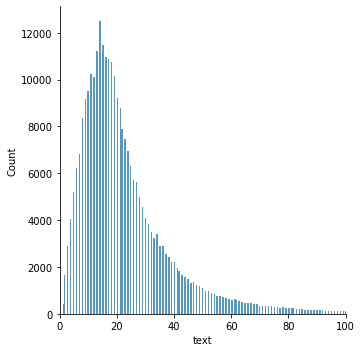

In [16]:
sns.displot(data['text'].apply(lambda i: len(i.split(" "))), kde=False)
plt.xlim(0, 100)

222287


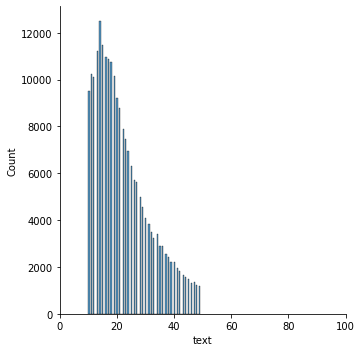

In [18]:
min_length = 10
max_length = 50

data_filtered = data.copy()
data_filtered['text_len'] = data_filtered['text'].apply(lambda i: len(i.split(" ")))
data_filtered = data_filtered.loc[(data_filtered['text_len'] >= min_length) & (data_filtered['text_len'] < max_length), ['uri', 'text']]

sns.displot(data_filtered['text'].apply(lambda i: len(i.split(" "))), kde=False)
plt.xlim(0, 100)
print(len(data_filtered))

## Export data

In [19]:
data_filtered.to_json("../data/text_all_processed.json", orient='records')